# 0. 필요 라이브러리 설치

In [1]:
!pip install torch matplotlib tqdm livelossplot gdown "pypianoroll>=1.0.2"

# 라이브러리 호출

In [2]:
from IPython.display import clear_output
import numpy as np
import torch
from pypianoroll import Multitrack, BinaryTrack
from tqdm import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
import matplotlib.pyplot as plt
import os
import pypianoroll
from pathlib import Path
import random
#from google.colab import files

os.makedirs('result', exist_ok=True)

# 기본파라미터 세팅

In [3]:
# Data
n_tracks = 1  # 사용되는 트랙의 수
n_pitches = 72  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 8  # number of samples to extract from each song in the datset
n_measures = 4  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
programs = [0]  # program number for each track
is_drums = [False]  # drum indicator for each track
track_names = ['Track 1']  # 트랙의 이름
tempo = 100

# Training
batch_size = 64
latent_dim = 1024
n_steps = 100000 # 학습 반복 횟수

# Sampling
sample_interval = 5000  # 학습 반복 횟수가 이 변수의 숫자만큼 반복되었을 시 현재까지 학습된 모델의 학습 진척도를 계산하여 출력해줌
n_samples = 4

measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)

# 학습에 사용하는 모델 및 함수 정의

In [4]:
# 정규화에 대한 그래디언트 페널티를 계산하여 생성기에 제공하는 그래디언트의 크기를 안정화한다.
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.size(0), 1).cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

'''
(5)
Reference : https://github.com/rosinality/stylegan2-pytorch/blob/master/train.py
def d_r1_loss(real_pred, real_img):
    with conv2d_gradfix.no_weight_gradients():
        grad_real, = autograd.grad(
            outputs=real_pred.sum(), inputs=real_img, create_graph=True
        )
    grad_penalty = grad_real.pow(2).reshape(grad_real.shape[0], -1).sum(1).mean()

    return grad_penalty
'''

# 그라디언트 및 손실 계산
def train_one_step(discriminator, generator, d_optimizer, g_optimizer, real_samples):
    """Train the networks for one step."""
    # Sample from the lantent distribution
    latent = torch.randn(batch_size, latent_dim)

    # Transfer data to GPU
    if torch.cuda.is_available():
        real_samples = real_samples.cuda()
        latent = latent.cuda()
    
    # === Train the discriminator ===
    # Reset cached gradients to zero
    d_optimizer.zero_grad()
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples)
    # Compute the loss function
    # d_loss_real = torch.mean(torch.nn.functional.relu(1. - prediction_real))
    d_loss_real = -torch.mean(prediction_real)
    # Backpropagate the gradients
    d_loss_real.backward()
    
    # Generate fake samples with the generator
    fake_samples = generator(latent)
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach())
    # Compute the loss function
    # d_loss_fake = torch.mean(torch.nn.functional.relu(1. + prediction_fake_d))
    d_loss_fake = torch.mean(prediction_fake_d)
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    '''
    Regularization loss
    10.0 coefficient
    0.01, 0.1, 1, 5, 10
    '''
    gradient_penalty = 10.0 * compute_gradient_penalty(discriminator, real_samples.data, fake_samples.data)
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()
    
    # === Train the generator ===
    # Reset cached gradients to zero
    g_optimizer.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

# 생성자 블록
class GeneraterBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.ConvTranspose2d(in_dim, out_dim, kernel, stride)
        self.transconv.weight.data.normal_(0, 0.02)#(1)
        '''
        (1)
        self.transconv.weight.data.normal_(0, 0.02)
        '''
        self.batchnorm = torch.nn.BatchNorm2d(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.batchnorm(x)
        #return torch.nn.functional.relu(x)
        return torch.nn.functional.gelu(x)
        '''
        (2)
        return torch.nn.functional.gelu(x)
        '''

# 생성자
class Generator(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        '''
        (3)
        1. kernel size, stride를 원래 MuseGAN의 예처럼 한쪽 axis씩 늘려보기
        2. 2씩 늘려보기
        '''
        self.transconv0 = GeneraterBlock(latent_dim, 256, (8, 1), (8, 1))
        self.transconv1 = GeneraterBlock(256, 64, (4, 2), (4, 2))
        self.transconv2 = GeneraterBlock(64, 32, (2, 3), (2, 3))
        self.transconv3 = GeneraterBlock(32, 32, (1, 3), (1, 3))
        self.transconv4 = GeneraterBlock(32, 1, (1, 4), (1, 4))

    def forward(self, x):
        x = x.view(-1, latent_dim, 1, 1)
        x = self.transconv0(x)
        x = self.transconv1(x)
        x = self.transconv2(x)
        x = self.transconv3(x)
        x = self.transconv4(x)
        x = x.view(-1, n_tracks, n_measures * measure_resolution, n_pitches)
        return x

# 정규화 레이어
class LayerNorm(torch.nn.Module):
    """An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959."""
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

# 판별자 블록
class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.Conv2d(in_dim, out_dim, kernel, stride)
        self.layernorm = LayerNorm(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.layernorm(x)
        return torch.nn.functional.leaky_relu(x)
        #return torch.nn.functional.gelu(x)#gelu로 변경

# 판별자
class Discriminator(torch.nn.Module):
    """A convolutional neural network (CNN) based discriminator. The
    discriminator takes as input either a real sample (in the training data) or
    a fake sample (generated by the generator) and outputs a scalar indicating
    its authentity.
    """
    def __init__(self):
        super().__init__()
        '''
        (4)
        1. Generator의 역에 가깝게 수정
        2. 마지막 dense layer의 input값이 너무 크지 않게 수정
        3. Linear layer를 제거 (Conv. layer를 통해서 1x1 사이즈까지 몰고 오도록...)
        '''
        self.conv0 = DiscriminatorBlock(1, 32, (1, 4), (1, 4))
        self.conv1 = DiscriminatorBlock(32, 64, (1, 3), (1, 3))
        self.conv2 = DiscriminatorBlock(64, 128, (2, 3), (2, 3))
        self.conv3 = DiscriminatorBlock(128, 256, (4, 2), (4, 2))
        self.conv4 = DiscriminatorBlock(256, 512, (8, 1), (8, 1))
        self.dense = torch.nn.Conv2d(512, 1, 1, 1)

    def forward(self, x):
        # (batch, channel=1, height=64, width=72)

        # (batch, 32, 64, 18)
        x = self.conv0(x)
        # (batch, 64, 64, 6)
        x = self.conv1(x)
        # (batch, 256, 32, 2)
        x = self.conv2(x)
        # (batch, 1024, 8, 1)
        x = self.conv3(x)
        # (batch, 1024, 1, 1)
        x = self.conv4(x)
        # (batch, 1, 1, 1)
        x = self.dense(x)
        # (batch, 1)
        x = x.view(x.size(0), 1)
        return x

# 데이터 전처리 함수(경우에 따라 생략 가능)

In [5]:
# # 현재 프로젝트 폴더의 하위 폴더(Ex: midis)에 학습할 midi파일을 삽입하면 자동으로 해당 폴더의 목록을 읽어서 dataloader가 읽을 수 있는 형태의 파일로 변환
# def preprocess(path_str, filename):
#   data = []
#   path = Path(path_str).glob('**/*')
#   # Load the multitrack as a pypianoroll.Multitrack instance
#   for name in path:
#       # multitrack = pypianoroll.load('lpd.npz')
#       try:
#           multitrack = pypianoroll.read(name)
#       except:
#           continue
#       # Binarize the pianorolls
#       multitrack.binarize()
#       # Downsample the pianorolls (shape: n_timesteps x n_pitches)
#       multitrack.set_resolution(beat_resolution)
#       # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
#       pianoroll = (multitrack.stack() > 0)
#       # Get the target pitch range only
#       pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches]
#       # Calculate the total measures
#       n_total_measures = multitrack.get_max_length() // measure_resolution
#       candidate = n_total_measures - n_measures
#       target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
#       # Randomly select a number of phrases from the multitrack pianoroll
#       for idx in np.random.choice(candidate, target_n_samples, False):
#           start = idx * measure_resolution
#           end = (idx + n_measures) * measure_resolution
#           # Skip the samples where some track(s) has too few notes
#           if (pianoroll.sum(axis=(1, 2)) < 10).any():
#               continue
#           data.append(pianoroll[:, start:end])
#   # Stack all the collected pianoroll segments into one big array
#   random.shuffle(data)
#   data = np.stack(data)
#   print(f"Data shape : {data.shape}")
#   np.savez_compressed(f'{filename}.npz', data=data)

# preprocess('midis', 'midis') # 첫번째 인자는 midi파일이 있는 폴더명, 두번째 인자는 결과물로 출력될 npz파일의 이름

데이터 전처리 작업을 위해 데이터셋 전체를 코랩에 업로드하는 것은 번거로우므로
위 작업은 로컬PC에서 수행하고 결과물만 코랩에 업로드하는 것이 좋음

파일업로드는 아래 코드 사용

In [6]:
# uploaded = files.upload() # 파일 업로드 기능 실행

# for fn in uploaded.keys(): # 업로드된 파일 정보 출력
#     print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# 전처리된 데이터 로딩

In [28]:
data = np.load('midis.npz')['data'] # 위 전처리 함수에서 생성된 npz파일을 사용
data = torch.as_tensor(data, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True) # 이 data_loader 객체가 추후 학습에 사용되는 데이터셋을 제어

# 모델 정의

In [29]:
discriminator = Discriminator() # 판별자
generator = Generator() # 생성자

print("Number of parameters in G: {}".format(sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

# Create optimizers
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.9))

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(n_samples, latent_dim)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

# Create a LiveLoss logger instance for monitoring
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])

Number of parameters in G: 2244867
Number of parameters in D: 1369633


# 학습

In [30]:
# liveloss.update({'d_loss': 2.0, 'g_loss': -3.0})
# liveloss.send()

In [ ]:
step = 0
# Create a progress bar instance for monitoring
progress_bar = tqdm(total=n_steps, initial=step, ncols=80, mininterval=1)

# Start iterations
running_d_loss, running_g_loss = 0.0, 0.0
while step < n_steps + 1:
    # Iterate over the dataset
    for real_samples in data_loader:
        # Train the neural networks
        generator.train()
        d_loss, g_loss = train_one_step(discriminator, generator, d_optimizer, g_optimizer, real_samples[0])
        d_loss = d_loss.data.cpu().numpy()
        g_loss = g_loss.data.cpu().numpy()

        # Record smoothened loss values to LiveLoss logger
        running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
        running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        # liveloss.update({'negative_critic_loss': -running_d_loss}) 
        liveloss.update({'d_loss': running_d_loss, 'g_loss': running_g_loss})

        # Update losses to progress bar
        progress_bar.set_description_str("(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))
        
        if step % sample_interval == 0:
            # Get generated samples
            generator.eval()
            # (batch, )
            samples = generator(sample_latent).cpu().detach().numpy()

            # Display loss curves
            clear_output(True)
            if step > 0:
                 liveloss.send() # liveloss 라이브러리를 사용하여 loss 출력
            
            # Display generated samples
            samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
            tracks = []
            for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
                pianoroll = np.pad(samples[idx] > 0.5,((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
                tracks.append(BinaryTrack(name=track_name,program=program,is_drum=is_drum,pianoroll=pianoroll))
                
            m = Multitrack(tracks=tracks,tempo=tempo_array,resolution=beat_resolution)
            
            m.write(f'result/{str(step).zfill(5)}.mid') # 중간 결과물을 result라는 폴더에 별도로 저장
            
        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break

(d_loss=-11.799786, g_loss= 10.875032):   1%| | 1226/100000 [00:50<1:07:47, 24.2

In [32]:
# array = np.array([1, 2, 3, 4])
# np.save('log.npy', array)
# loaded_array = np.load('log.npy', allow_pickle=True)
# print(array == loaded_array)
# !ls

# 테스트
- 학습 코드에서 중간 결과물 생성시에 사용했던 과정을 일부 재사용하여 결과물 생성

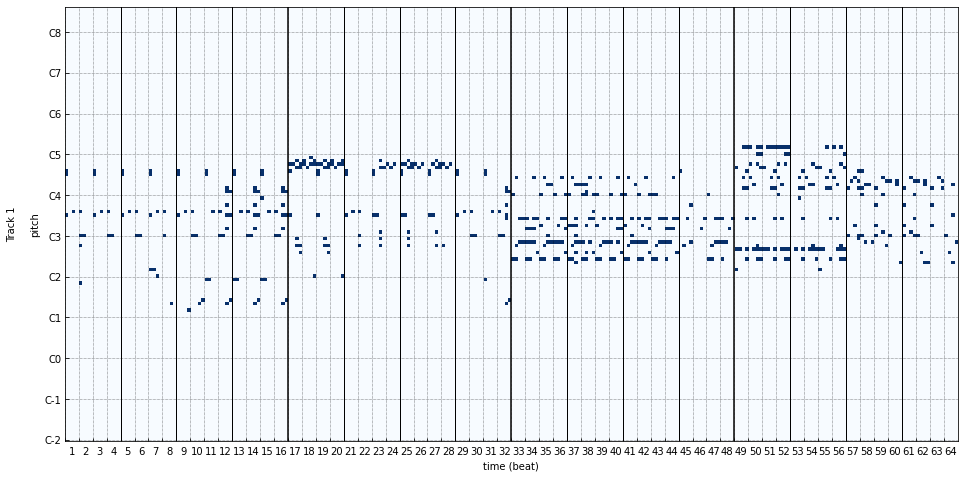

In [23]:
generator.eval()

sample_latent = torch.randn(n_samples, latent_dim)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

samples = generator(sample_latent).cpu().detach().numpy()

# Display generated samples
samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(samples[idx] > 0.5,((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
    tracks.append(BinaryTrack(name=track_name,program=program,is_drum=is_drum,pianoroll=pianoroll))
m = Multitrack(tracks=tracks,tempo=tempo_array,resolution=beat_resolution)

axs = m.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(measure_resolution,4 * measure_resolution * n_measures,measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)

plt.show()
m.write('result.mid') # 프로젝트 폴더에 result.mid 라는 파일이 결과물로 생성됨

In [24]:
# files.download('result.mid') # 코랩 사용시 결과물 확인을 위해서는 파일을 별도로 다운 받아야함

# 모델 저장
학습 과정에서 생성된 generator 객체를 파일로 저장하여 추후 학습 없이 음악을 생성할 수 있도록 함

In [25]:
import pickle
with open('epoch_10000.pkl', 'wb') as f:
    pickle.dump(generator, f)

In [26]:
# files.download('epoch_10000.pkl')# 코랩 사용시 결과물 확인을 위해서는 파일을 별도로 다운 받아야함


# 모델 로드
- 학습 과정을 생략하고 바로 결과물을 생성해야 할 때 기 생성된 generator 객체를 로드하기 위한 작업
- 위 모델 저장 과정에서 생성된 pkl 파일만 사용 가능

In [16]:
with open('generator.pkl', 'rb') as f:
    generator = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'generator.pkl'